In [1]:
# !ls ./

In [5]:
import zipfile

zip_file_path = './MAPI Mayeek.zip'
extract_dir = './MAPI Mayee/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the target directory
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")


Files extracted to: ./MAPI Mayee/


In [89]:
# !pip install easyfsl
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

# from easyfsl.samplers import TaskSampler
# from easyfsl.utils import plot_images, sliding_average


In [90]:
import os
import random
from collections import defaultdict
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PrototypicalOmniglotDataset(Dataset):
    def __init__(self, root, num_classes=1623, n_shot=5, n_query=10, transform=None):
        self.root = root
        self.num_classes = num_classes
        self.n_shot = n_shot
        self.n_query = n_query
        self.transform = transform
        self.samples_by_label = defaultdict(list)
        self.all_imgs = {}
        self.classes = []

        # Common image file extensions
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']

        # Organize data into classes and image paths
        for alphabet in os.listdir(self.root):
            alphabet_path = os.path.join(self.root, alphabet)
            if not os.path.isdir(alphabet_path):
                continue

            for char_class in os.listdir(alphabet_path):
                char_class_path = os.path.join(alphabet_path, char_class)

                # Skip if the entry is not a directory
                if not os.path.isdir(char_class_path):
                    continue

                all_images = []
                for img_name in os.listdir(char_class_path):
                    img_path = os.path.join(char_class_path, img_name)

                    # Check if it's a file with a recognized image extension
                    if os.path.isfile(img_path) and any(img_name.lower().endswith(ext) for ext in image_extensions):
                        all_images.append(img_path)

                if all_images:
                    char_class_name = f"{alphabet}_{char_class}"
                    self.samples_by_label[char_class_name] = list(range(len(all_images)))
                    self.all_imgs[char_class_name] = all_images
                    self.classes.append(char_class_name)

    # def transform_image(self, raw_img):
    #     img = ImageOps.invert(raw_img)
    #     if self.transform is not None:
    #         img = self.transform(img)
    #     return img
    def transform_image(self, raw_img):
        img = raw_img#ImageOps.invert(raw_img)
        if self.transform is not None:
            # print(self.transform)
            img = self.transform(img)
        # print(img.shape)
        return img

    def __getitem__(self, index):
        selected_classes = random.sample(self.classes, self.num_classes)
        class_indices = [self.samples_by_label[each_cls] for each_cls in selected_classes]

        support_set = []
        query_set = []
        label_id = 0
        qs=[]
        for idx_set in class_indices:
            # Creating support set
            selected_support = random.sample(idx_set, self.n_shot)
            support_images = [self.transform_image(Image.open(self.all_imgs[selected_classes[label_id]][each]).convert('L')) for each in selected_support]

            # Creating query set
            selected_query = random.sample(idx_set, self.n_query)
            query_images = [self.transform_image(Image.open(self.all_imgs[selected_classes[label_id]][each]).convert('L')) for each in selected_query]
            support_set.append((support_images, [label_id for _ in range(self.n_shot)]))
            # print("aaaaaaaaaa",label_id)
            query_set.append((query_images,  [label_id for _ in range(self.n_query)]))

            label_id += 1
            # qs= [item for item in a for _ in range(self.n_query)]
        return support_set, query_set

    def __len__(self):
        return 10

# Set up the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
])


root_path = '../olchiki'
num_classes = 5  # Set the desired number of classes per episode
n_shot = 5
n_query = 10

PrototypicalOmniglotDatasetLoader = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)


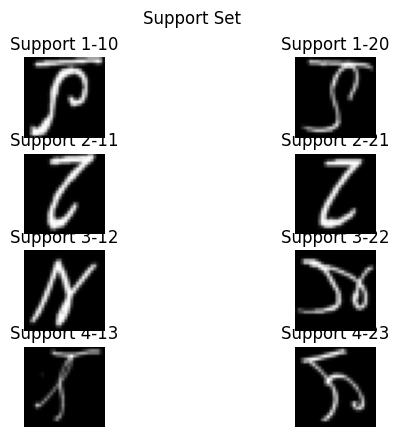

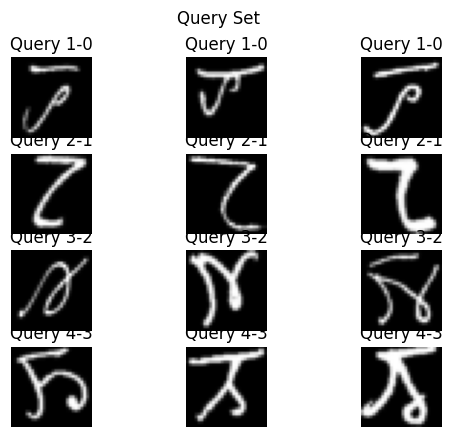

In [92]:

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
])


# Set up the PrototypicalOmniglotDatasetLoader
root_path ='./MAPI Mayee'
num_classes = 4
n_shot = 2
n_query = 3

dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a PrototypicalNetwork model
# model = PrototypicalNetwork(num_classes=num_classes).to(device)

# Set the model to evaluation mode
# model.eval()

# Choose an episode to visualize
episode_index = 10  # Change this to the desired episode index

# Get support set and query set for the chosen episode
support_set, query_set = dataset[episode_index]

# Visualize support set
for i, (support_images, lbl) in enumerate(support_set):
    for j, img in enumerate(support_images):
        plt.subplot(len(support_set), len(support_images), i * len(support_images) + j + 1)
        plt.imshow(img[0], cmap='gray')  # Assuming the image is grayscale
        plt.axis('off')
        plt.title(f'Support {i + 1}-{j + 1}{lbl[j]}')

plt.suptitle('Support Set')
plt.show()

# Visualize query set
for i, (query_images, ll) in enumerate(query_set):
    for j, img in enumerate(query_images):
        plt.subplot(len(query_set), len(query_images), i * len(query_images) + j + 1)
        plt.imshow(img[0], cmap='gray')  # Assuming the image is grayscale
        plt.axis('off')
        plt.title(f'Query {i + 1}-{ll[j]}')

plt.suptitle('Query Set')
plt.show()


In [93]:
import torch
import torch.nn as nn

class PrototypicalNetworks3(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks3, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images,
        support_labels,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        num_classes=len(list(support_labels))
        prototypes = []
        for class_label in range(num_classes):
            # print(type(support_images[class_label]),torch.cat(support_images[class_label].shape)
            support_images_eachclass=(support_images[class_label])
            class_features = self.backbone(support_images_eachclass.to(device))  # Select features for the current class
            class_prototype = class_features.mean(dim=0)  # Compute the mean along the batch dimension
            prototypes.append(class_prototype)
        prototypes = torch.stack(prototypes)



        query_features = self.backbone(query_images)

        # Compute the distance between query features and prototypes
        distances = torch.cdist(query_features, prototypes)

        return -distances


In [95]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch
import torch.nn as nn
import torch.hub

# Define a modified version of DenseNet169 with dropout after each convolutional layer
class DenseNet169WithDropout(nn.Module):
    def __init__(self,modell, pretrained=False, dr=0.4):
        super(DenseNet169WithDropout, self).__init__()
        self.densenet169 = torch.hub.load('pytorch/vision:v0.10.0', modell, pretrained=pretrained)
        self.dropout = nn.Dropout(p=dr)  # Dropout with probability 0.5

        # Modify each dense block to include dropout after each convolutional layer
        for name, module in self.densenet169.features.named_children():
            if isinstance(module, nn.Sequential):
                for sub_name, sub_module in module.named_children():
                    if isinstance(sub_module, nn.Conv2d):
                        setattr(module, sub_name, nn.Sequential(sub_module, self.dropout))

    def forward(self, x):
        return self.densenet169(x)

# Instantiate the modified DenseNet169 model with dropout
# convolutional_network_with_dropout = DenseNet169WithDropout(modell='resnet18',pretrained=False,dr=0.4)

# Example usage:
# output = convolutional_network_with_dropout(input_tensor)

class ResNet18WithDropout(nn.Module):
    def __init__(self, pretrained=False, dr=0.4):
        super(ResNet18WithDropout, self).__init__()
        self.resnet18 = models.resnet18(pretrained=pretrained)
        self.dropout = nn.Dropout(p=dr)

        # Modify each residual block to include dropout after each convolutional layer
        for name, module in self.resnet18.named_children():
            if isinstance(module, nn.Sequential):
                for sub_name, sub_module in module.named_children():
                    if isinstance(sub_module, nn.Conv2d):
                        setattr(module, sub_name, nn.Sequential(sub_module, self.dropout))

    def forward(self, x):
        return self.resnet18(x)

# Instantiate the modified ResNet18 model with dropout
# convolutional_network_with_dropout = ResNet18WithDropout(pretrained=False, dr=0.4)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import defaultdict
from PIL import Image, ImageOps
import os
import random


transform = transforms.Compose([
    transforms.Resize(68),
    transforms.RandomResizedCrop(64),  # Randomly crop the image and resize to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0, 0), scale=(0.9, 1.1), shear=0),  # Random zoom (scaling)
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image with ImageNet statistics
])
#background == Training

root_path = './MAPI Mayee/'
num_classes = 5
n_shot = 1
n_query = 15
# generate_random_params_trainloader()
print(f"Generated random values - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convolutional_network_with_dropout=FinalBlockk( in_channels=3, growth_rate=3,dimension=64, block_config="none", drop_rate=0.0)
convolutional_network_with_dropout =  DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()

model = PrototypicalNetworks3(convolutional_network_with_dropout).to(device)  # Assuming you have PrototypicalNetworks defined

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters:", total_params)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
episode_losses = []
#num_episodes = len(dataset)
#print(num_episodes)
for episode in range(20):



    support_set, query_set = dataset[episode]

    # Convert data to tensors and move to device
    support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
    query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

    # Forward pass
    support_images, support_labels = zip(*support_set)
    query_images, query_labels = zip(*query_set)
    # print(len(support_images),len(support_labels),type(support_images[0]),support_labels,)

    # support_images = torch.cat(support_images)
    # support_labels = torch.tensor(support_labels).to(device)
    query_images = torch.cat(query_images)
    query_labels = torch.tensor(query_labels).to(device)
    query_labels = query_labels.view(-1)
    tskloss = 0
    ta=""
    # print(query_labels)
    for i in range(30):
      model.train()

      classification_scores = model(support_images, support_labels, query_images)
      # print(classification_scores.shape)


      loss = criterion(classification_scores, query_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      tskloss+=loss.item()
      if(i==0 or i==29):
        predicted_labels = torch.argmax(classification_scores, dim=1)
        pp=predicted_labels.tolist()
        act=query_labels.tolist()
        cortt=0
        for iii in range(len(pp)):
          if pp[iii] == act[iii]:
              cortt = cortt + 1
        print("Traning accuracy: ",cortt/len(pp))
        ta="Training Accuracy: ,"+str(cortt/len(pp))
      print("    --->>>   episode",episode,"mini_epoch:",i,"  train loss: ",loss.item())

# Calculate the total number of matching values
# total_matching_values = sum(matching_counts)

    episode_losses.append(tskloss)
    num_classes = random.choice([5,10,7,8,9])  # Random number of classes (e.g., between 3 and 10)
    n_shot = random.randint(1,3)       # Random number of support examples per class (e.g., between 5 and 15)
    n_query = 15-n_shot
    dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)
    print(f"Generated  Tasks - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

    if  episode==19:
      torch.save(model.state_dict(), './mapi_sce/Denssecondary/model_1/model_B_mapi_1-shot_dens__'+str(episode)+'.pth')



In [ ]:
!pwd

In [12]:
!mkdir './mapi_sce/Denssecondary/model_10/'


mkdir: cannot create directory ‘./asamese_sce/lwcnnsecondary/model_10/’: File exists


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import defaultdict
from PIL import Image, ImageOps
import os
import random


transform = transforms.Compose([
    transforms.Resize(68),
    transforms.RandomResizedCrop(64),  # Randomly crop the image and resize to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0, 0), scale=(0.9, 1.1), shear=0),  # Random zoom (scaling)
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image with ImageNet statistics
])
#background == Training

root_path = './MAPI Mayee/'
num_classes = 5
n_shot = 5
n_query = 15
# generate_random_params_trainloader()
print(f"Generated random values - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convolutional_network_with_dropout=FinalBlockk( in_channels=3, growth_rate=3,dimension=64, block_config="none", drop_rate=0.0)
convolutional_network_with_dropout =  DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()

model = PrototypicalNetworks3(convolutional_network_with_dropout).to(device)  # Assuming you have PrototypicalNetworks defined

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters:", total_params)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
episode_losses = []
#num_episodes = len(dataset)
#print(num_episodes)
for episode in range(20):



    support_set, query_set = dataset[episode]

    # Convert data to tensors and move to device
    support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
    query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

    # Forward pass
    support_images, support_labels = zip(*support_set)
    query_images, query_labels = zip(*query_set)
    # print(len(support_images),len(support_labels),type(support_images[0]),support_labels,)

    # support_images = torch.cat(support_images)
    # support_labels = torch.tensor(support_labels).to(device)
    query_images = torch.cat(query_images)
    query_labels = torch.tensor(query_labels).to(device)
    query_labels = query_labels.view(-1)
    tskloss = 0
    ta=""
    # print(query_labels)
    for i in range(30):
      model.train()

      classification_scores = model(support_images, support_labels, query_images)
      # print(classification_scores.shape)


      loss = criterion(classification_scores, query_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      tskloss+=loss.item()
      if(i==0 or i==29):
        predicted_labels = torch.argmax(classification_scores, dim=1)
        pp=predicted_labels.tolist()
        act=query_labels.tolist()
        cortt=0
        for iii in range(len(pp)):
          if pp[iii] == act[iii]:
              cortt = cortt + 1
        print("Traning accuracy: ",cortt/len(pp))
        ta="Training Accuracy: ,"+str(cortt/len(pp))
      print("    --->>>   episode",episode,"mini_epoch:",i,"  train loss: ",loss.item())

# Calculate the total number of matching values
# total_matching_values = sum(matching_counts)

    episode_losses.append(tskloss)
    num_classes = random.choice([5,10,7,8,9])  # Random number of classes (e.g., between 3 and 10)
    n_shot = random.randint(3, 6)       # Random number of support examples per class (e.g., between 5 and 15)
    n_query = 14-n_shot
    dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)
    print(f"Generated  Tasks - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

    if episode==19:
      torch.save(model.state_dict(), './mapi_sce/Denssecondary/model_5/model_B_mapi_5-shot_dens_'+str(episode)+'.pth')



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import defaultdict
from PIL import Image, ImageOps
import os
import random


transform = transforms.Compose([
    transforms.Resize(68),
    transforms.RandomResizedCrop(64),  # Randomly crop the image and resize to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0, 0), scale=(0.9, 1.1), shear=0),  # Random zoom (scaling)
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image with ImageNet statistics
])
#background == Training

root_path = './MAPI Mayee/'
num_classes = 5
n_shot = 5
n_query = 15
# generate_random_params_trainloader()
print(f"Generated random values - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

convolutional_network_with_dropout =  DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model = PrototypicalNetworks3(convolutional_network_with_dropout).to(device)  # Assuming you have PrototypicalNetworks defined

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters:", total_params)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
episode_losses = []
#num_episodes = len(dataset)
#print(num_episodes)
for episode in range(20):



    support_set, query_set = dataset[episode]

    # Convert data to tensors and move to device
    support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
    query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

    # Forward pass
    support_images, support_labels = zip(*support_set)
    query_images, query_labels = zip(*query_set)
    # print(len(support_images),len(support_labels),type(support_images[0]),support_labels,)

    # support_images = torch.cat(support_images)
    # support_labels = torch.tensor(support_labels).to(device)
    query_images = torch.cat(query_images)
    query_labels = torch.tensor(query_labels).to(device)
    query_labels = query_labels.view(-1)
    tskloss = 0
    ta=""
    # print(query_labels)
    for i in range(30):
      model.train()

      classification_scores = model(support_images, support_labels, query_images)
      # print(classification_scores.shape)


      loss = criterion(classification_scores, query_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      tskloss+=loss.item()
      if(i==0 or i==29):
        predicted_labels = torch.argmax(classification_scores, dim=1)
        pp=predicted_labels.tolist()
        act=query_labels.tolist()
        cortt=0
        for iii in range(len(pp)):
          if pp[iii] == act[iii]:
              cortt = cortt + 1
        print("Traning accuracy: ",cortt/len(pp))
        ta="Training Accuracy: ,"+str(cortt/len(pp))
      print("    --->>>   episode",episode,"mini_epoch:",i,"  train loss: ",loss.item())

# Calculate the total number of matching values
# total_matching_values = sum(matching_counts)

    episode_losses.append(tskloss)
    num_classes = random.choice([5,10,7,8,9])  # Random number of classes (e.g., between 3 and 10)
    n_shot = random.randint(8, 11)       # Random number of support examples per class (e.g., between 5 and 15)
    n_query = 15-n_shot
    dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)
    print(f"Generated  Tasks - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

    if episode==19:
      torch.save(model.state_dict(), './mapi_sce/Denssecondary/model_10/model_B_mapi_10-shot_dens_'+str(episode)+'.pth')

